In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt

# Replace these with your W&B project and group details
WANDB_PROJECT = "Hypergradient-RL"  # e.g., "my-reinforcement-learning-project"
WANDB_ENTITY = "rl-power"  # e.g., "my-username"

EXP_NAME = ["CartPole", "Acrobot"]
BEXP_NAME = ["walker2d",
            "halfcheetah", 
            "hopper", 
            "humanoid", 
            # "inverted_pendulum", 
            "reacher", 
            # "humanoidstandup", 
            "pusher", 
            "inverted_double_pendulum"]
ALGO_NAME = ["Nystrom", "CG", "Nested", "vanilla"]

api = wandb.Api()
# Fetch all runs in the project
all_runs = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")
runs_dict = {}

# Filter runs for EXP_NAME
for exp in EXP_NAME:
    runs_dict[exp] = {}  # Initialize this key as a dictionary
    for algo in ALGO_NAME:
        runs_dict[exp][algo] = [
            run for run in all_runs
            # Ensure run.group is not None, and exclude runs with "G0" or "test" in the group name
            if run.group is not None 
               and ("G0" not in run.group)  # Exclude runs with "G0" in the group name
               and ("test" not in run.group)  # Exclude runs with "test" in the group name
               and (exp in run.group) 
               and (algo in run.group)
               and (("500000" in run.group) if exp == "CartPole" else True)
        ]

# Filter runs for BEXP_NAME
for exp in BEXP_NAME:
    runs_dict[exp] = {}  # Initialize this key as a dictionary
    for algo in ALGO_NAME:
        algo_name = algo
        if algo == "Nystrom": 
            algo_name = "Nystrom1"
        elif algo == "vanilla":
            algo_name = "vannila"
        runs_dict[exp][algo] = [
            run for run in all_runs
            # Ensure run.group is not None, and exclude runs with "G0" or "test" in the group name
            if run.group is not None 
               and ("G0" not in run.group)  # Exclude runs with "G0" in the group name
               and ("test" not in run.group)  # Exclude runs with "test" in the group name
               and ("VF" not in run.group if exp == "walker2d" else True)
               and (exp + "_" in run.group) 
               and (algo_name in run.group)
        ]

# Now `runs_dict` contains filtered runs for each experiment and algorithm

In [2]:
for exp, algo_dict in runs_dict.items():
    for algo, run_list in algo_dict.items():
        # The number of runs for this (exp, algo)
        print(f"Experiment: {exp}, Algorithm: {algo}, Number of runs: {len(run_list)}")

        # Check if the experiment is "walker2d" and the algorithm is "vanilla"
        if exp == "walker2d" and algo == "vanilla":
            for run in run_list:
                print(f"Group name: {run.group}")

Experiment: CartPole, Algorithm: Nystrom, Number of runs: 5
Experiment: CartPole, Algorithm: CG, Number of runs: 5
Experiment: CartPole, Algorithm: Nested, Number of runs: 5
Experiment: CartPole, Algorithm: vanilla, Number of runs: 13
Experiment: Acrobot, Algorithm: Nystrom, Number of runs: 5
Experiment: Acrobot, Algorithm: CG, Number of runs: 5
Experiment: Acrobot, Algorithm: Nested, Number of runs: 5
Experiment: Acrobot, Algorithm: vanilla, Number of runs: 5
Experiment: walker2d, Algorithm: Nystrom, Number of runs: 5
Experiment: walker2d, Algorithm: CG, Number of runs: 5
Experiment: walker2d, Algorithm: Nested, Number of runs: 5
Experiment: walker2d, Algorithm: vanilla, Number of runs: 5
Group name: walker2d_lr0.00025_vannila
Group name: walker2d_lr0.00025_vannila
Group name: walker2d_lr0.00025_vannila
Group name: walker2d_lr0.00025_vannila
Group name: walker2d_lr0.00025_vannila
Experiment: halfcheetah, Algorithm: Nystrom, Number of runs: 5
Experiment: halfcheetah, Algorithm: CG, Num

In [3]:
import numpy as np

def time_weighted_smoothing(x_values, y_values, smoothing_param, viewport_scale=1.0):
    """
    Apply time-weighted smoothing to y_values based on x_values.
    
    Parameters:
        x_values (list or np.array): The x-axis values (e.g., steps or time).
        y_values (list or np.array): The y-axis values (e.g., rewards or metrics).
        smoothing_param (float): The base smoothing parameter (alpha).
        viewport_scale (float): Scaling factor for the x-axis range (default: 1.0).
    
    Returns:
        np.array: Smoothed y-values.
    """
    # Ensure inputs are numpy arrays
    x_values = np.array(x_values)
    y_values = np.array(y_values)
    
    # Compute the range of x-values
    range_of_x = x_values.max() - x_values.min()
    if range_of_x == 0:
        range_of_x = 1  # Avoid division by zero
    
    # Compute the base smoothing weight
    smoothing_weight = min(np.sqrt(smoothing_param), 0.999)
    
    # Initialize variables
    last_y = 0 if len(y_values) > 0 else np.nan
    debias_weight = 0
    smoothed_values = []
    
    for index in range(len(y_values)):
        # Compute change in x
        prev_x = x_values[index - 1] if index > 0 else x_values[0]
        change_in_x = ((x_values[index] - prev_x) / range_of_x) * viewport_scale
        
        # Adjust smoothing weight
        smoothing_weight_adj = smoothing_weight ** change_in_x
        
        # Update smoothed value and debias weight
        last_y = last_y * smoothing_weight_adj + y_values[index]
        debias_weight = debias_weight * smoothing_weight_adj + 1
        
        # Append debiased smoothed value
        smoothed_values.append(last_y / debias_weight)
    
    return np.array(smoothed_values)

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import FuncFormatter

# Custom formatter function
def scientific_formatter(x, pos):
    """Format numbers in scientific notation without leading zeros in the exponent."""
    exponent = int(np.log10(abs(x))) if x != 0 else 0  # Calculate the exponent
    base = x / (10**exponent)  # Calculate the base
    return f"{int(base)}e{exponent}"

algo_colors = {
    "Nystrom": ("red", 0.8),
    "vanilla": ("blue", 0.8),
    "CG": ("green", 0.8),
    "Nested": ("yellow", 0.8),
}

exp_alpha = {
    "CartPole": 0.1,
    "Acrobot": 0.05,
    "walker2d": 0.05,
    "halfcheetah": 0.05, 
    "hopper": 0.05, 
    "humanoid": 0.05,
    "inverted_pendulum": 0.05, 
    "reacher": 0.05, 
    "humanoidstandup": 0.05, 
    "pusher": 0.05, 
    "inverted_double_pendulum": 0.05,
}

def plot_runs_dict(runs_dict, metrics_to_plot=["Reward"], x_key="_step", algos_to_plot=None):
    plt.style.use("ggplot")   # Modern clean style
    
    os.makedirs("plots", exist_ok=True)  # Ensure plots folder exists
    
    for exp, algo_dict in runs_dict.items():
        fig, ax = plt.subplots(figsize=(8, 6))  # Wider figure for better clarity
        plotted_algos = []
        
        for algo, runs_list in algo_dict.items():
            if algos_to_plot and algo not in algos_to_plot:
                continue
            if not runs_list:
                continue
            
            plotted_algos.append(algo)
            
            for metric in metrics_to_plot:
                df_list = []
                for run in runs_list:
                    hist = run.history(pandas=True)
                    if hist is None or hist.empty or metric not in hist.columns or x_key not in hist.columns:
                        continue
                    df_tmp = hist[[x_key, metric]].dropna()
                    df_list.append(df_tmp)
                
                if not df_list:
                    continue
                
                # Merge runs
                merged = df_list[0].rename(columns={metric: f"{metric}_0"})
                for i, df_seed in enumerate(df_list[1:], start=1):
                    merged = merged.merge(
                        df_seed.rename(columns={metric: f"{metric}_{i}"}),
                        on=x_key, how="outer"
                    )
                
                merged = merged.sort_values(x_key).reset_index(drop=True)
                
                # Smooth data
                seed_cols = [c for c in merged.columns if c.startswith(f"{metric}_")]
                for col in seed_cols:
                    merged[col] = merged[col].ewm(alpha=exp_alpha[exp], adjust=False).mean()
                
                # Mean and 95% CI
                merged["mean"] = merged[seed_cols].mean(axis=1)
                merged["std"] = merged[seed_cols].std(axis=1)
                n_seeds = len(seed_cols)
                ci95 = 1.96 * merged["std"] / np.sqrt(n_seeds)
                
                algo_display_name = {
                    "Nystrom": "BL-Nyström-PPO (ours)",
                    "vanilla": "PPO",
                    "CG": "BL-CG-PPO",
                    "Nested": "PPO-Nested",
                }.get(algo, algo)
                
                # Plot
                ax.plot(
                    merged[x_key],
                    merged["mean"],
                    label=algo_display_name,
                    linewidth=2,
                    color=algo_colors[algo][0],
                    alpha=algo_colors[algo][1],
                )
                ax.fill_between(
                    merged[x_key],
                    merged["mean"] - ci95,
                    merged["mean"] + ci95,
                    alpha=0.2,
                    color=algo_colors[algo][0]
                )
        
        # Customize axis labels
        ax.set_xlabel("Steps" if x_key == "_step" else x_key, fontsize=14)
        ax.set_ylabel("Episodic Return", fontsize=14)
        ax.tick_params(axis="both", labelsize=12)
        
        # Use scientific notation for x-axis
        ax.xaxis.set_major_formatter(FuncFormatter(scientific_formatter))
        
        # Grid and legend
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend(
            fontsize=12,
            framealpha=0.9,
            loc="upper center",
            bbox_to_anchor=(0.5, 1.15),
            ncol=min(len(plotted_algos), 4),  # Adjust columns based on the number of algorithms
        )
        
        plt.tight_layout()
        
        if plotted_algos:
            algo_names = "_".join(plotted_algos)
            filename = f"plots/{exp}_{algo_names}.png"
            plt.savefig(filename, dpi=300, bbox_inches="tight")
            print(f"Saved plot to {filename}")
        
        plt.show()

Saved plot to plots/CartPole_Nystrom_vanilla.png


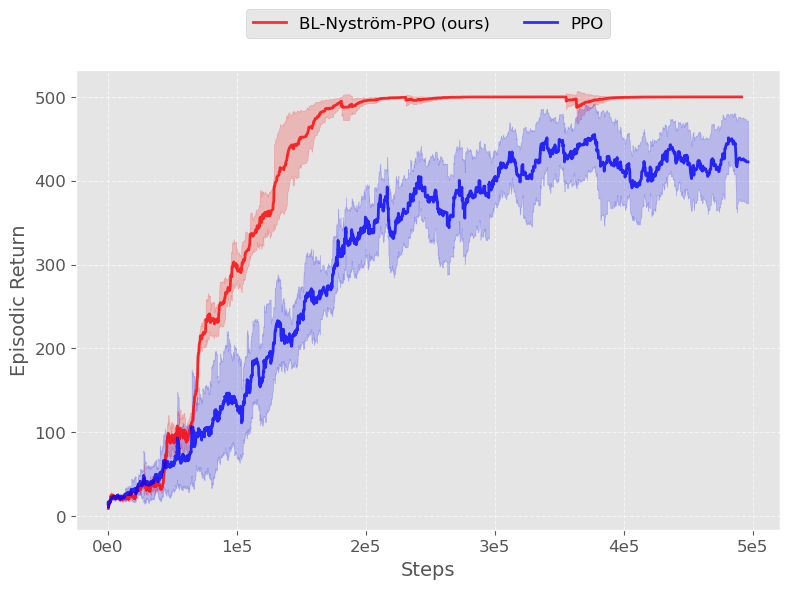

Saved plot to plots/Acrobot_Nystrom_vanilla.png


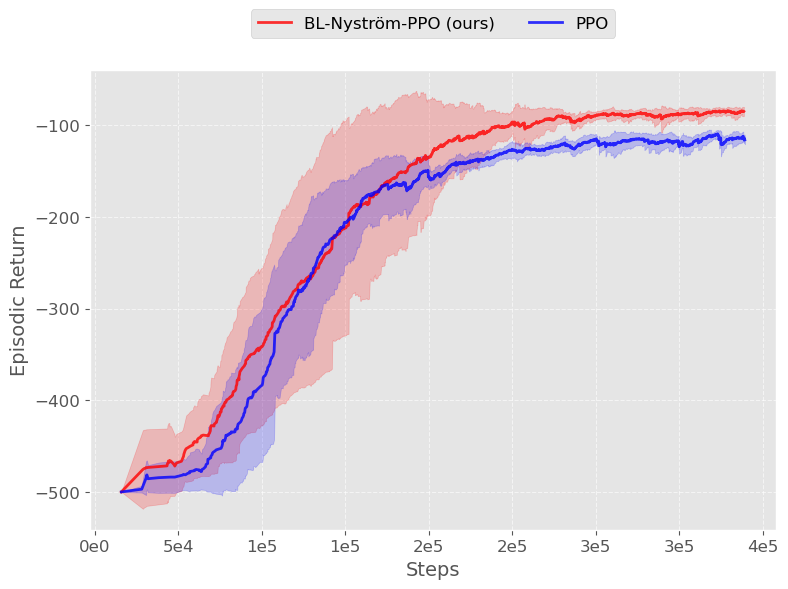

Saved plot to plots/walker2d_Nystrom_vanilla.png


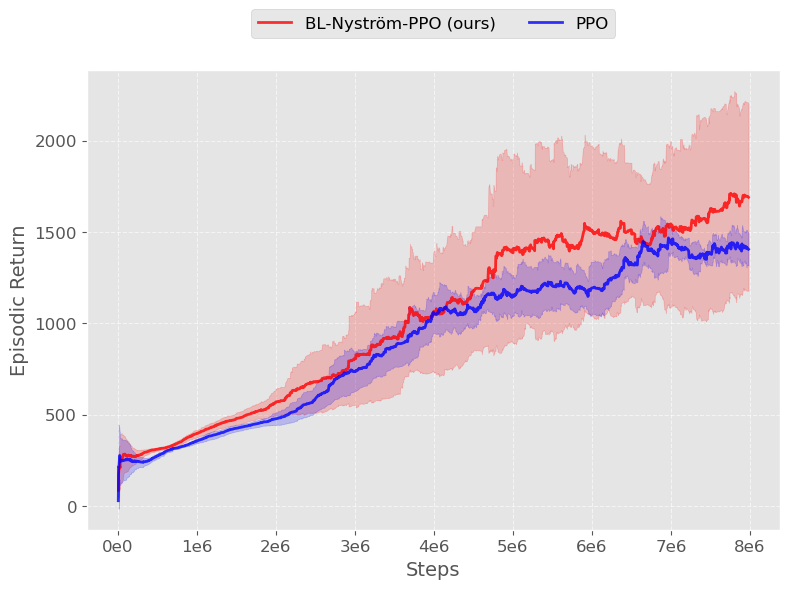

Saved plot to plots/halfcheetah_Nystrom_vanilla.png


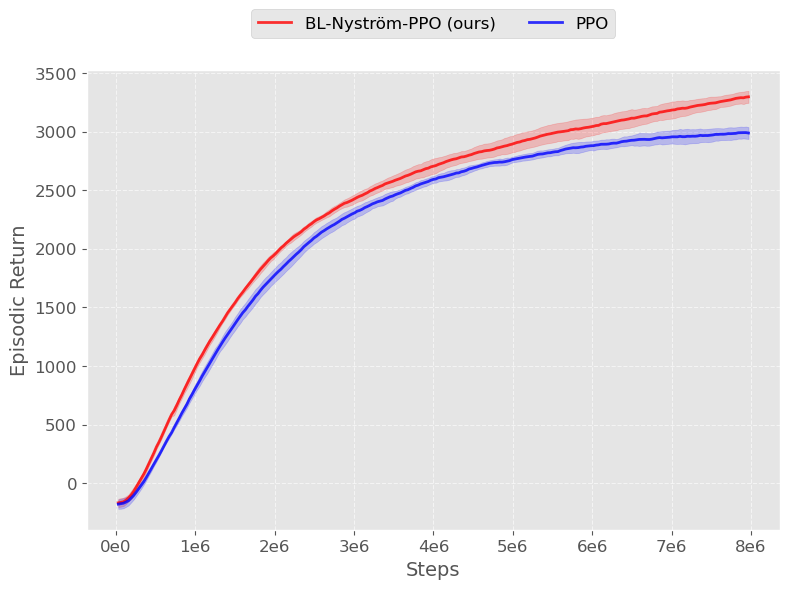

Saved plot to plots/hopper_Nystrom_vanilla.png


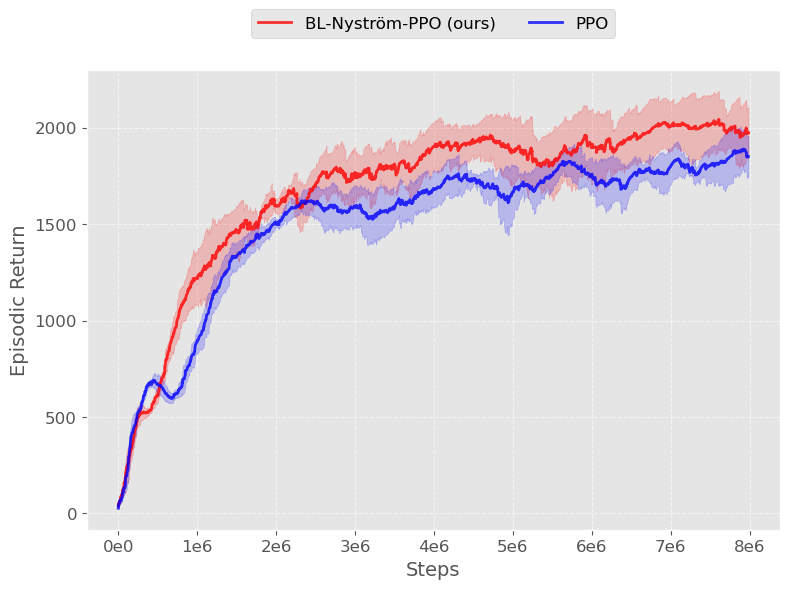

Saved plot to plots/humanoid_Nystrom_vanilla.png


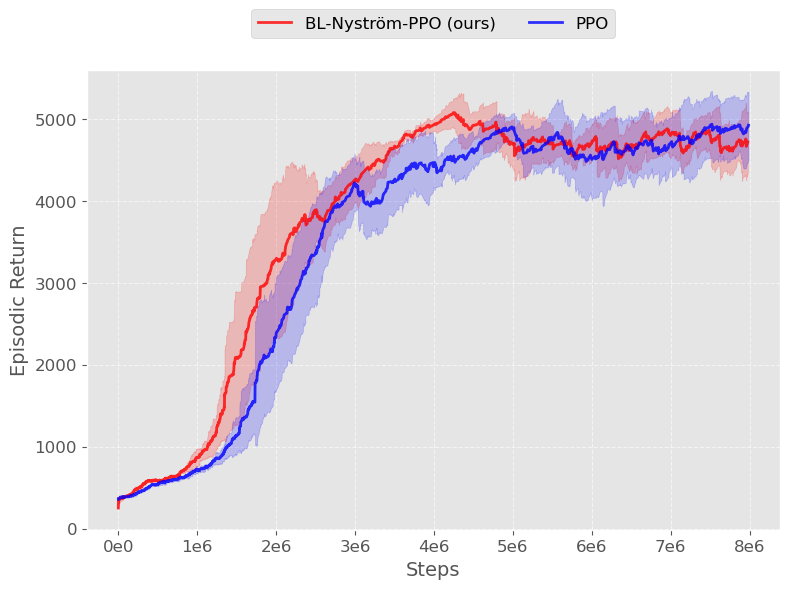

Saved plot to plots/reacher_Nystrom_vanilla.png


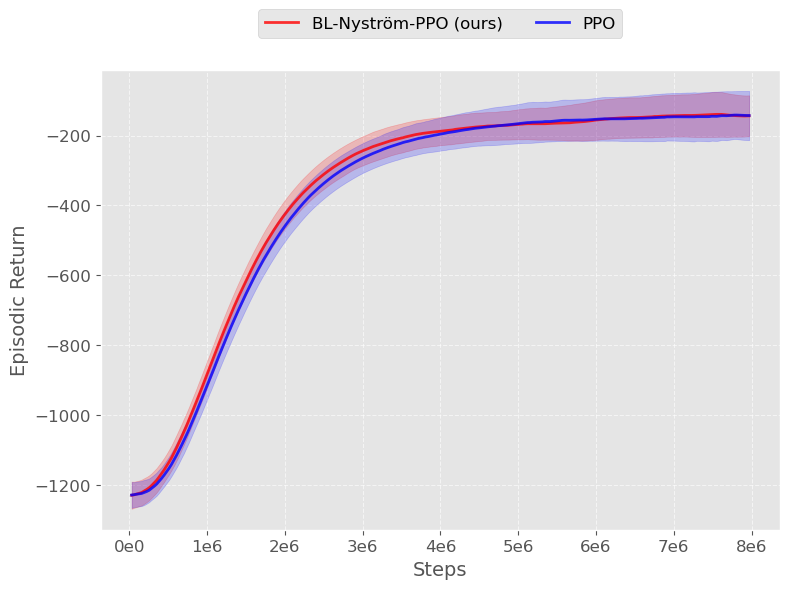

Saved plot to plots/pusher_Nystrom_vanilla.png


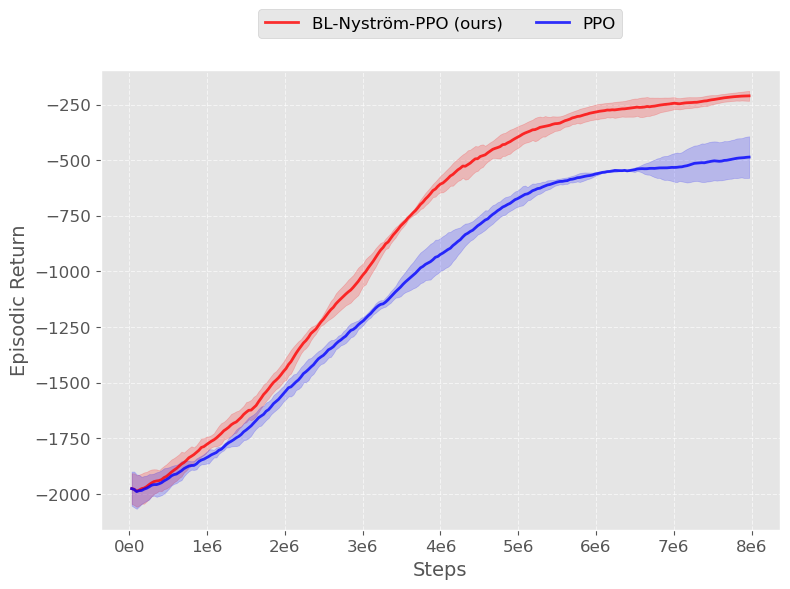

Saved plot to plots/inverted_double_pendulum_Nystrom_vanilla.png


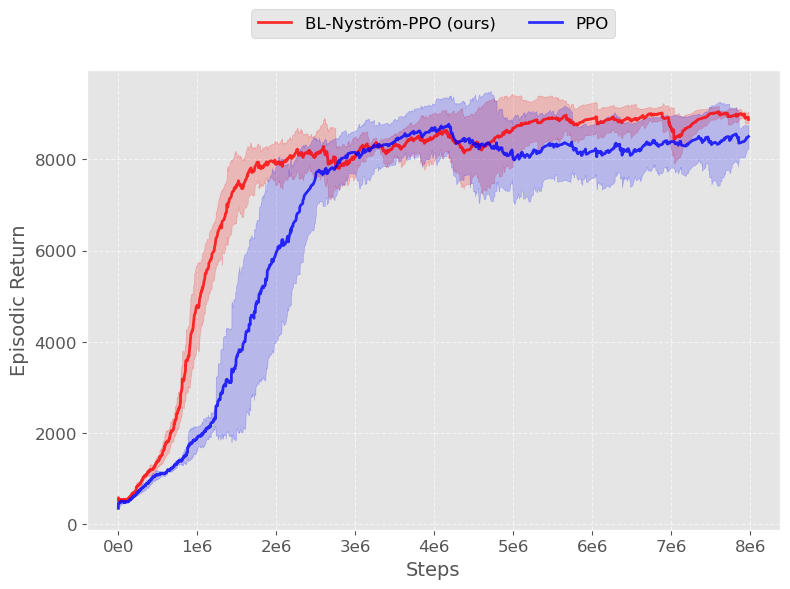

In [5]:
algos_to_plot = [ "vanilla",
                #  "Nested",
                #  "CG", 
                "Nystrom", ]

plot_runs_dict(runs_dict, metrics_to_plot=["Reward"], algos_to_plot=algos_to_plot)

Saved plot to plots/CartPole_Nystrom_CG.png


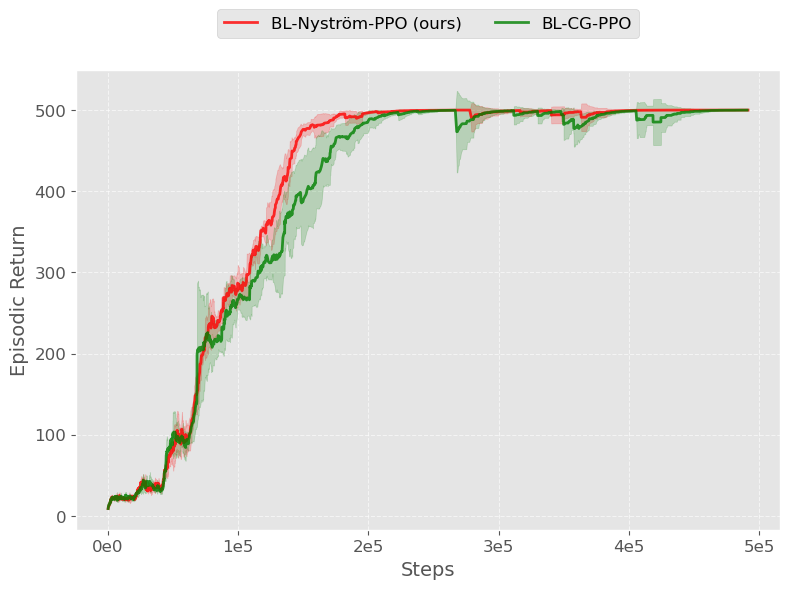

Saved plot to plots/Acrobot_Nystrom_CG.png


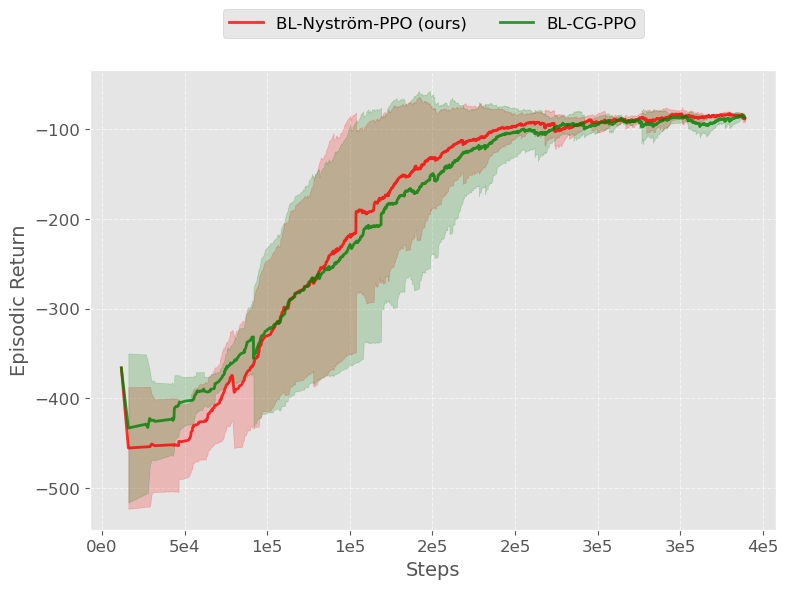

Saved plot to plots/walker2d_Nystrom_CG.png


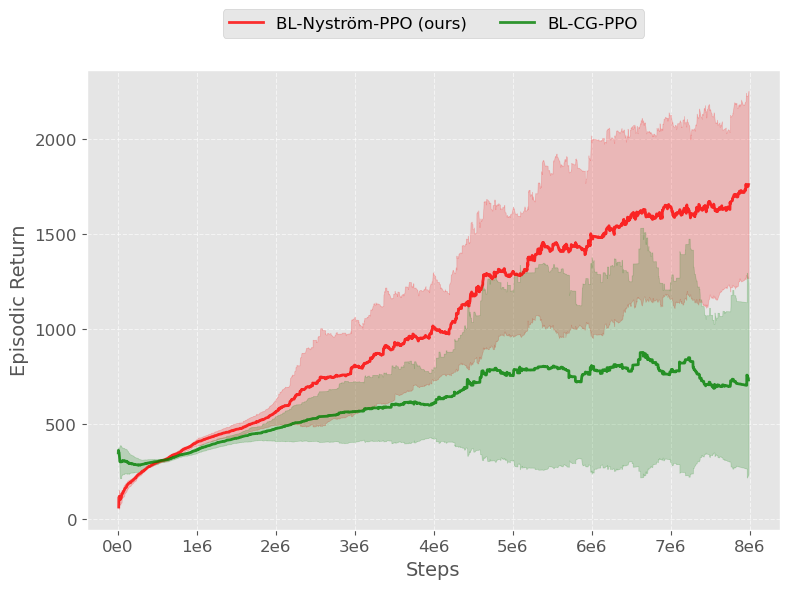

Saved plot to plots/halfcheetah_Nystrom_CG.png


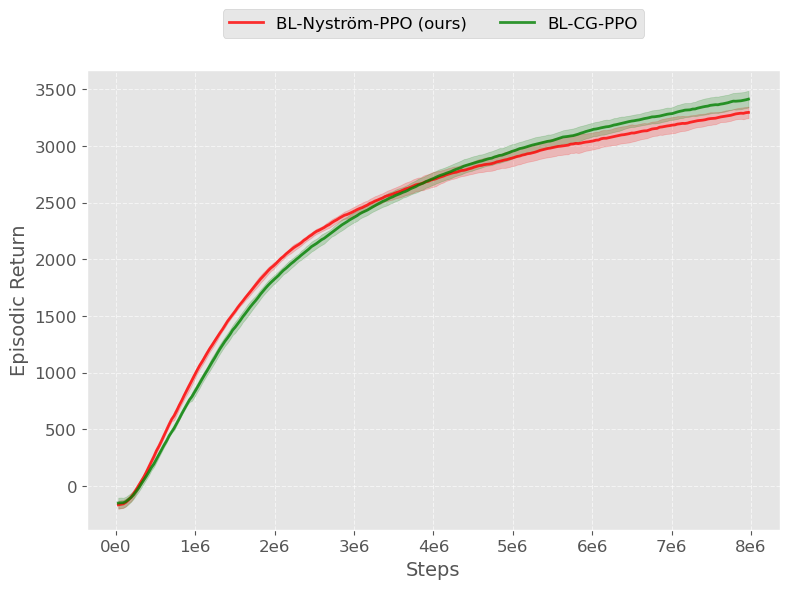

Saved plot to plots/hopper_Nystrom_CG.png


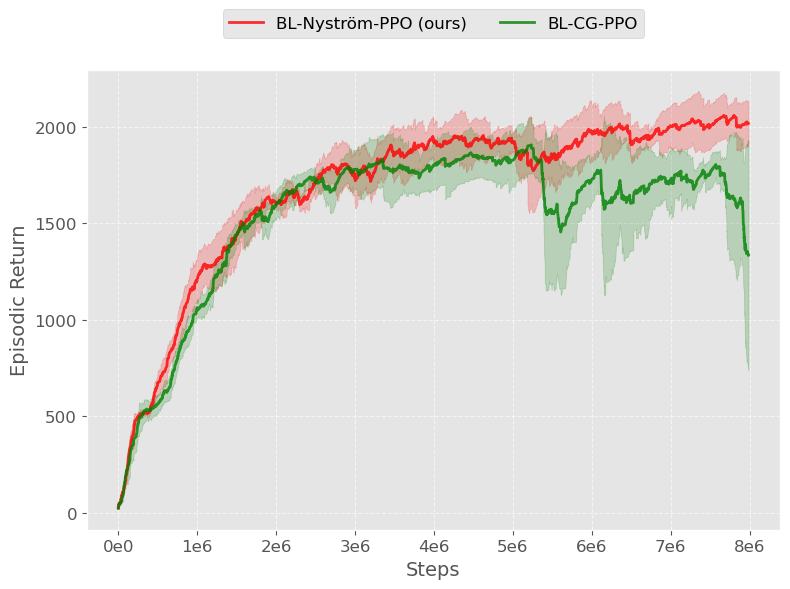

Saved plot to plots/humanoid_Nystrom_CG.png


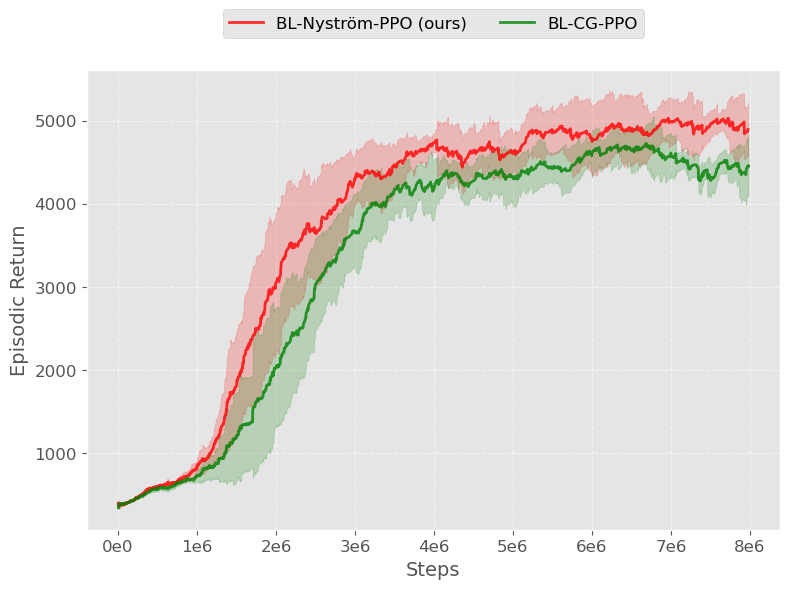

Saved plot to plots/reacher_Nystrom_CG.png


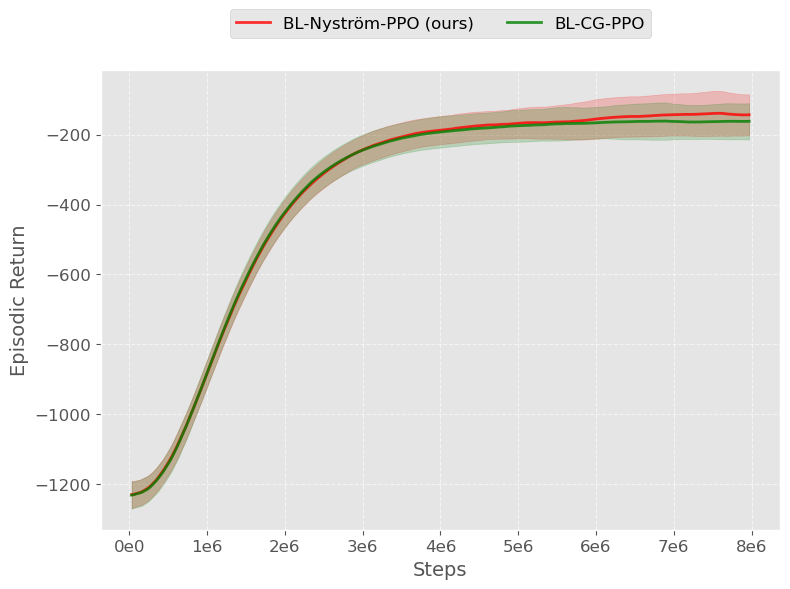

Saved plot to plots/pusher_Nystrom_CG.png


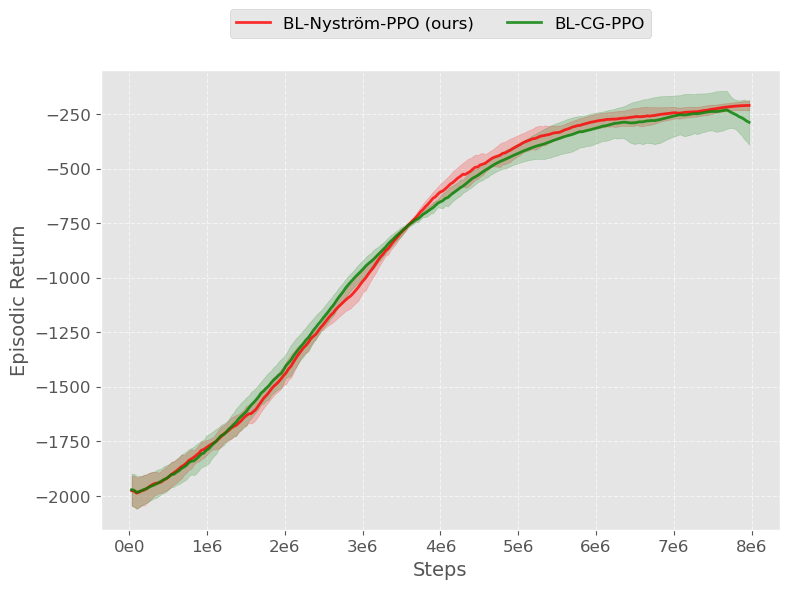

Saved plot to plots/inverted_double_pendulum_Nystrom_CG.png


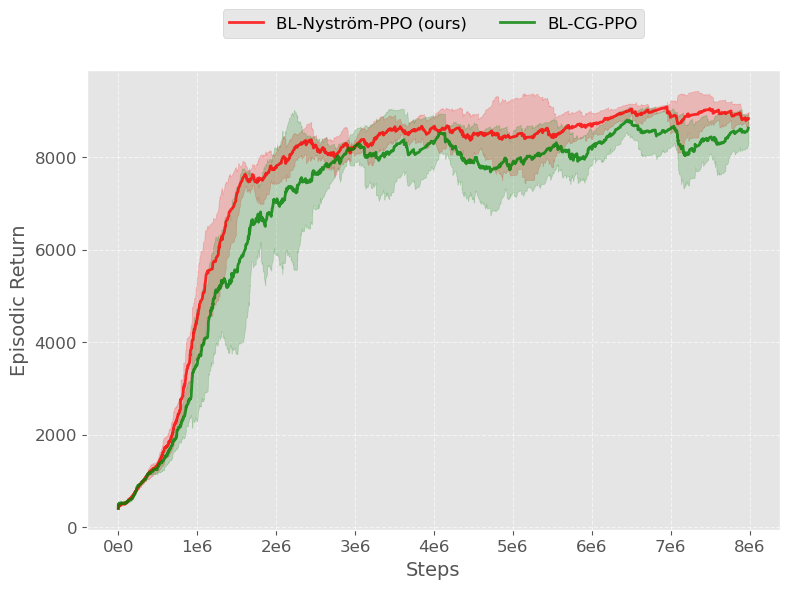

In [6]:
algos_to_plot = [ 
                # "vanilla",
                #  "Nested",
                 "CG", 
                "Nystrom", ]

plot_runs_dict(runs_dict, metrics_to_plot=["Reward"], algos_to_plot=algos_to_plot)

Saved plot to plots/CartPole_Nystrom_CG_Nested_vanilla.png


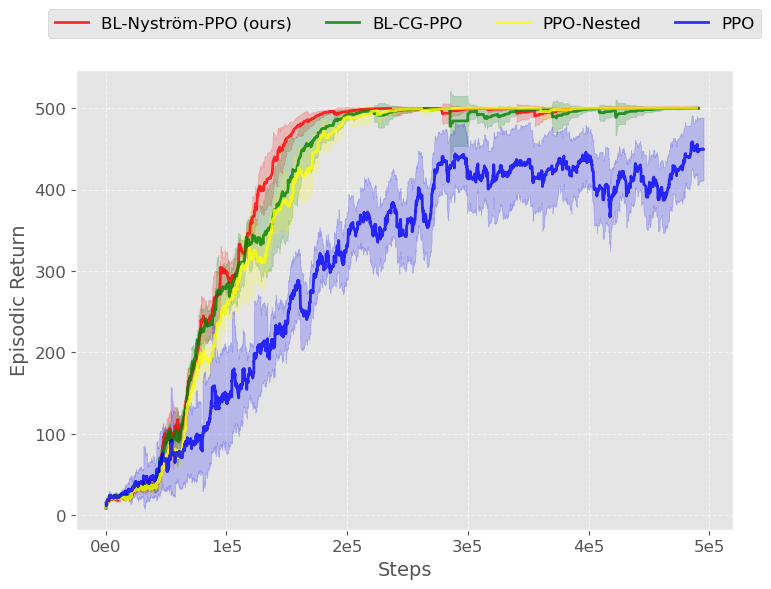

Saved plot to plots/Acrobot_Nystrom_CG_Nested_vanilla.png


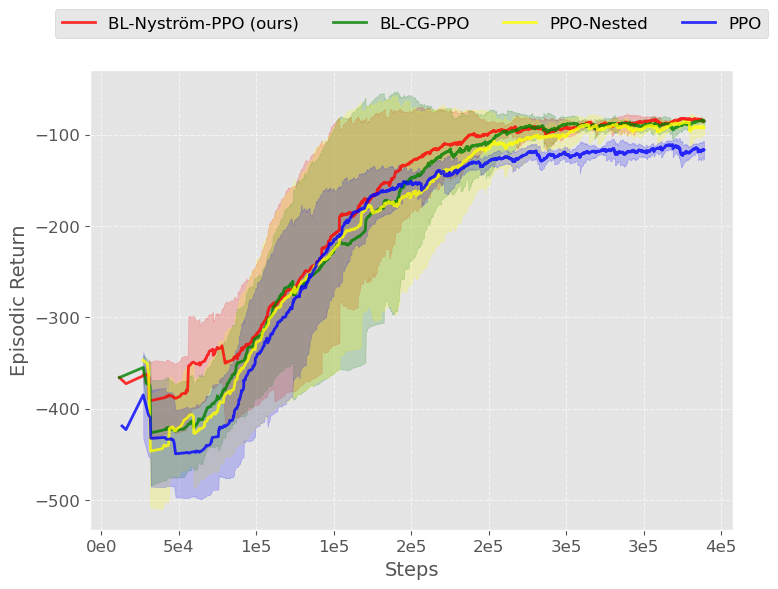

Saved plot to plots/walker2d_Nystrom_CG_Nested_vanilla.png


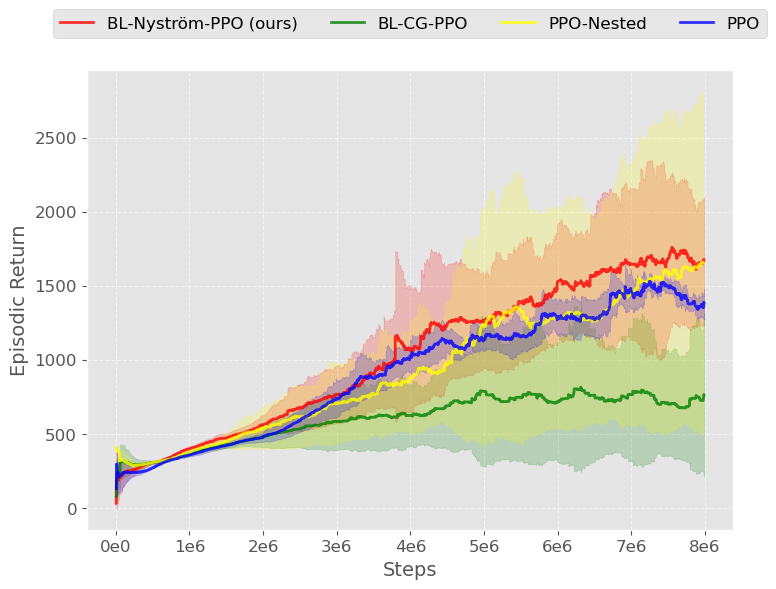

Saved plot to plots/halfcheetah_Nystrom_CG_Nested_vanilla.png


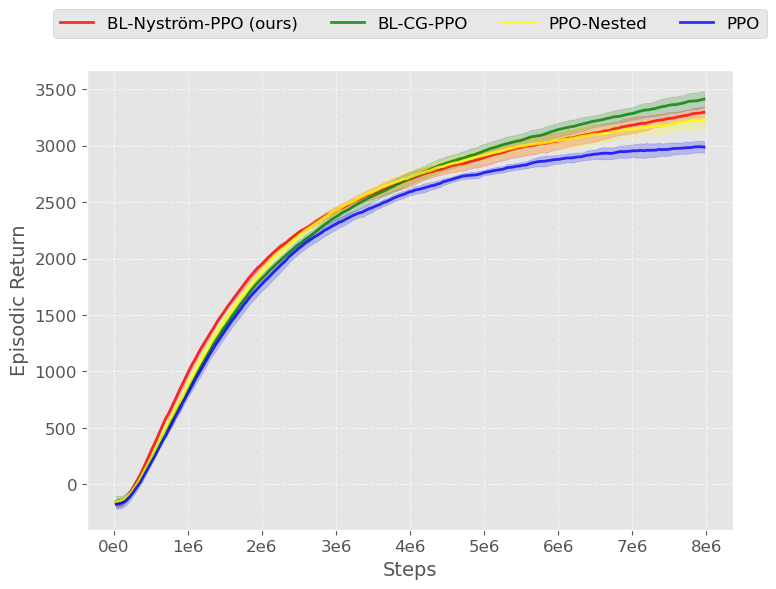

Saved plot to plots/hopper_Nystrom_CG_Nested_vanilla.png


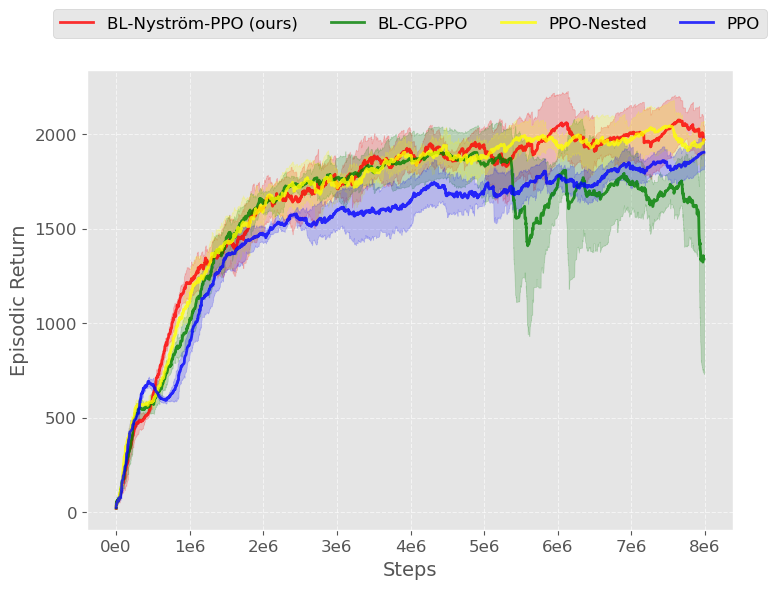

Saved plot to plots/humanoid_Nystrom_CG_Nested_vanilla.png


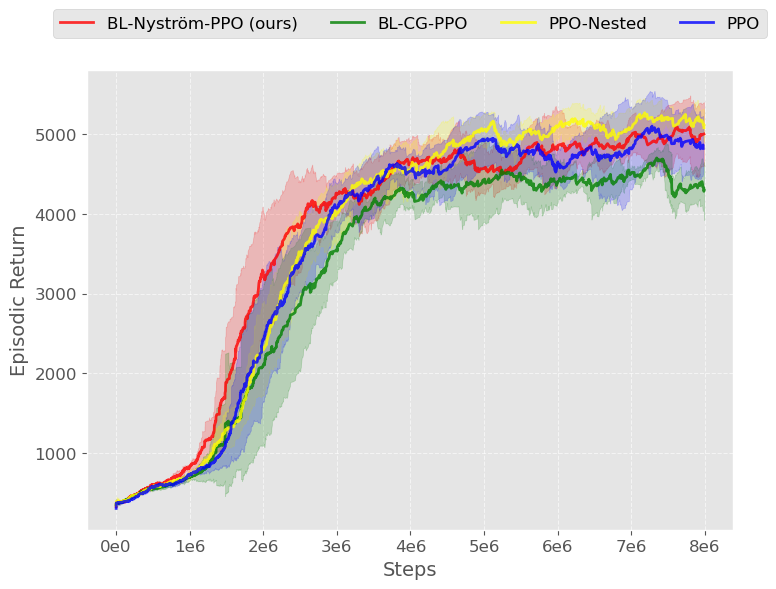

Saved plot to plots/reacher_Nystrom_CG_Nested_vanilla.png


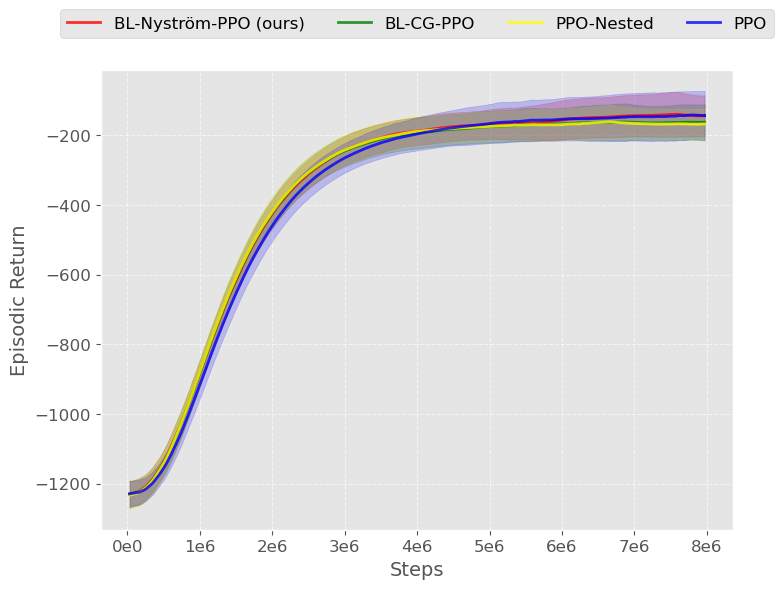

Saved plot to plots/pusher_Nystrom_CG_Nested_vanilla.png


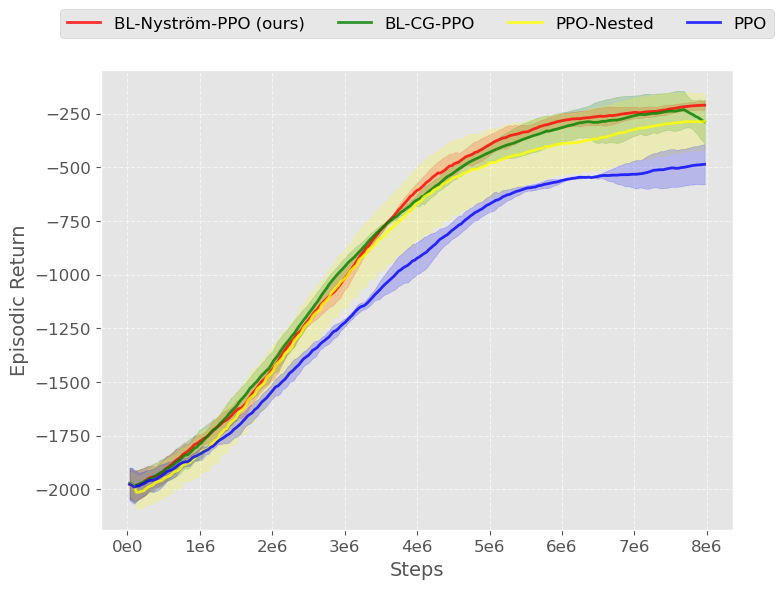

Saved plot to plots/inverted_double_pendulum_Nystrom_CG_Nested_vanilla.png


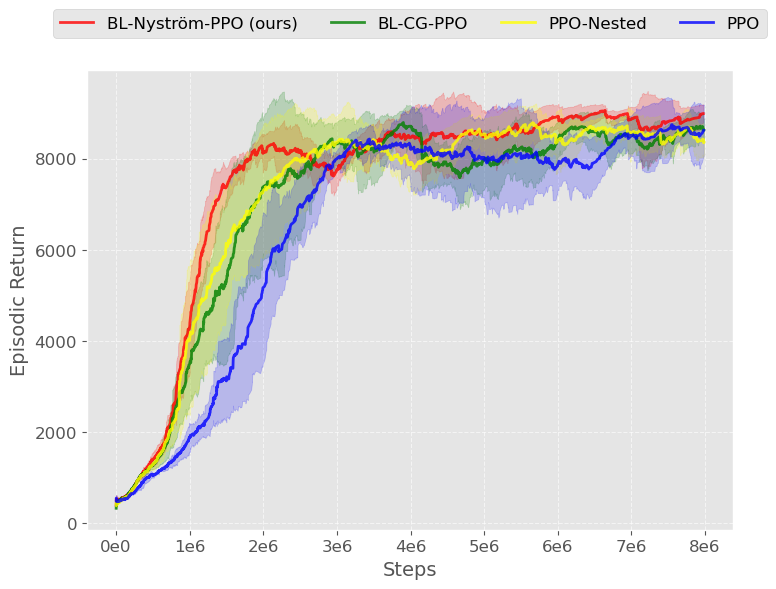

In [7]:
algos_to_plot = [ 
                "vanilla",
                 "Nested",
                 "CG", 
                "Nystrom", ]

plot_runs_dict(runs_dict, metrics_to_plot=["Reward"], algos_to_plot=algos_to_plot)

In [27]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Replace these with your W&B project and group details
WANDB_PROJECT = "Hypergradient-RL"
WANDB_ENTITY = "rl-power"

CHART_NAME = {
    "Nystrom": "BL-Nyström-PPO(ours)",
    "CG": "BL-CG-PPO",
    "Nested": "PPO",
}

# Create a directory to save the plots if it doesn't exist
if not os.path.exists("runtime_plots"):
    os.makedirs("runtime_plots")

api = wandb.Api()
# Fetch all runs in the project
all_runs = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")
runs_dict = {}

EXP_NAME = ["CartPole", "Acrobot"]
BEXP_NAME = ["walker2d",
            "halfcheetah", 
            "hopper", 
            "humanoid", 
            # "inverted_pendulum", 
            # "reacher", 
            # "humanoidstandup", 
            "pusher", 
            "inverted_double_pendulum"]
ALGO_NAME = ["Nystrom", "CG", "Nested"]

api = wandb.Api()
# Fetch all runs in the project
all_runs = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")
runs_dict = {}

# Filter runs for EXP_NAME
for exp in EXP_NAME:
    runs_dict[exp] = {}  # Initialize this key as a dictionary
    for algo in ALGO_NAME:
        runs_dict[exp][algo] = [
            run for run in all_runs
            # Ensure run.group is not None, and exclude runs with "G0" or "test" in the group name
            if run.group is not None 
               and ("G0" not in run.group)  # Exclude runs with "G0" in the group name
               and ("test" not in run.group)  # Exclude runs with "test" in the group name
               and (exp in run.group) 
               and (algo in run.group)
               and (("500000" in run.group) if exp == "CartPole" else True)
        ]

# Filter runs for BEXP_NAME
for exp in BEXP_NAME:
    runs_dict[exp] = {}  # Initialize this key as a dictionary
    for algo in ALGO_NAME:
        algo_name = algo
        if algo == "Nystrom": 
            algo_name = "Nystrom1"
        elif algo == "vanilla":
            algo_name = "vannila"
        runs_dict[exp][algo] = [
            run for run in all_runs
            # Ensure run.group is not None, and exclude runs with "G0" or "test" in the group name
            if run.group is not None 
               and ("G0" not in run.group)  # Exclude runs with "G0" in the group name
               and ("test" not in run.group)  # Exclude runs with "test" in the group name
               and ("VF" not in run.group if exp == "walker2d" else True)
               and (exp + "_" in run.group) 
               and (algo_name in run.group)
        ]

# Extract runtime data
runtime_data = {}
pureenv_runtimes = {}
for exp in EXP_NAME + BEXP_NAME:
    runtime_data[exp] = {}
    for algo in ALGO_NAME:
        runtimes = [run.summary['_runtime'] for run in runs_dict[exp][algo] if '_runtime' in run.summary]
        if runtimes:
            runtime_data[exp][algo] = {'mean': np.mean(runtimes), 'std': np.std(runtimes)}
        else:
            runtime_data[exp][algo] = None
    # Pureenv data
    pureenv_runs = [run for run in all_runs if run.group is not None and "pureenv" in run.group and exp in run.group]
    pureenv_runtimes[exp] = {
        'min': min([run.summary['_runtime'] for run in pureenv_runs if '_runtime' in run.summary], default=None)
    }

def plot_grouped_bars(env_list, filename, title):
    x_labels = env_list
    x = np.arange(len(x_labels))  # The label locations
    width = 0.2  # Width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))

    # Color mapping for each algorithm
    colors = {
        "Nystrom": "red",
        "CG": "green",
        "Nested": "blue"
    }

    # Offset for grouped bars
    for i, algo in enumerate(ALGO_NAME):
        means = [runtime_data[exp][algo]['mean'] if runtime_data[exp][algo] else 0 for exp in x_labels]
        stds = [runtime_data[exp][algo]['std'] if runtime_data[exp][algo] else 0 for exp in x_labels]
        ax.bar(x + i * width, means, width, label=CHART_NAME[algo], color=colors[algo], yerr=stds, capsize=5)

    # Add horizontal black lines for environmental runtimes
    for i, exp in enumerate(x_labels):
        if pureenv_runtimes[exp]['min'] is not None:
            ax.axhline(
                y=pureenv_runtimes[exp]['min'],
                color='black',
                linestyle='--',
                xmin=i / len(x_labels),
                xmax=(i + 1) / len(x_labels),
                label="Estimated Environmental Time" if i == 0 else ""
            )

    # Formatting
    # ax.set_xlabel("Environments")
    ax.set_ylabel("Average Runtime (seconds)")
    # ax.set_title(title)
    ax.set_xticks(x + width)
    ax.set_xticklabels(x_labels, rotation=45, ha="right")
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Save and show the figure
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()

# Generate separate plots
plot_grouped_bars(
    EXP_NAME,
    "runtime_plots/cartpole_acrobot_runtime_comparison.png",
    "Runtime Comparison: CartPole and Acrobot"
)

plot_grouped_bars(
    BEXP_NAME,
    "runtime_plots/brax_envs_runtime_comparison.png",
    "Runtime Comparison: Other Environments"
)


In [22]:
# Create a table with algorithms as columns and environments as rows
table_data = []
algorithms_to_include = ["vanilla", "CG", "Nystrom"]  # Include "vanilla" in the algorithm list

for exp in EXP_NAME + BEXP_NAME:
    row = [exp]  # First column is the experiment name
    for algo in algorithms_to_include:
        if runtime_data[exp][algo] is not None:
            mean = runtime_data[exp][algo]['mean']
            std = runtime_data[exp][algo]['std']
            row.append(f"{mean:.2f} ± {std:.2f}")  # Format as "mean ± std"
        else:
            row.append("N/A")  # No data available
    
    # Add slowdown vs vanilla for each algorithm (excluding vanilla itself)
    if runtime_data[exp]["vanilla"] is not None:
        vanilla_mean = runtime_data[exp]["vanilla"]['mean']
        for algo in algorithms_to_include:
            if algo != "vanilla" and runtime_data[exp][algo] is not None:
                algo_mean = runtime_data[exp][algo]['mean']
                if vanilla_mean > 0:  # Avoid division by zero
                    slowdown_factor = algo_mean / vanilla_mean
                    row.append(f"{slowdown_factor:.2f}x")
                else:
                    row.append("N/A")
            elif algo != "vanilla":
                row.append("N/A")
    else:
        row.extend(["N/A"] * (len(algorithms_to_include) - 1))  # No vanilla data available
    
    table_data.append(row)

# Create a DataFrame for the table
# Columns: Experiment, vanilla, CG, Nested, Slowdown (CG), Slowdown (Nested)
columns = ["Experiment"] + algorithms_to_include + [f"Slowdown vs Vanilla ({algo})" for algo in algorithms_to_include if algo != "vanilla"]
table_df = pd.DataFrame(table_data, columns=columns)

# Display the table
print(table_df)

# Optionally, save the table to a CSV file
table_df.to_csv("runtime_comparison_table_inverted.csv", index=False)

KeyError: 'vanilla'

In [17]:
# Create a table with CG and Nystrom algorithms as columns and environments as rows
table_data_cg_nystrom = []
algorithms_to_compare = ["CG", "Nystrom"]  # Only include CG and Nystrom

for exp in EXP_NAME + BEXP_NAME:
    row = [exp]  # First column is the experiment name
    for algo in algorithms_to_compare:
        if runtime_data[exp][algo] is not None:
            mean = runtime_data[exp][algo]['mean']
            std = runtime_data[exp][algo]['std']
            row.append(f"{mean:.2f} ± {std:.2f}")  # Format as "mean ± std"
        else:
            row.append("N/A")  # No data available
    
    # # Add slowdown vs vanilla for CG and Nystrom
    # if runtime_data[exp]["vanilla"] is not None:
    #     vanilla_mean = runtime_data[exp]["vanilla"]['mean']
    #     for algo in algorithms_to_compare:
    #         if runtime_data[exp][algo] is not None:
    #             algo_mean = runtime_data[exp][algo]['mean']
    #             if vanilla_mean > 0:  # Avoid division by zero
    #                 slowdown_factor = algo_mean / vanilla_mean
    #                 row.append(f"{slowdown_factor:.2f}x")
    #             else:
    #                 row.append("N/A")
    #         else:
    #             row.append("N/A")
    # else:
    #     row.extend(["N/A"] * len(algorithms_to_compare))  # No vanilla data available
    
    table_data_cg_nystrom.append(row)

# Create a DataFrame for the table
# Columns: Experiment, CG (mean ± std), Nystrom (mean ± std), Slowdown vs Vanilla (CG), Slowdown vs Vanilla (Nystrom)
columns_cg_nystrom = ["Experiment"] + algorithms_to_compare 
# + [f"Slowdown vs Vanilla ({algo})" for algo in algorithms_to_compare]
table_df_cg_nystrom = pd.DataFrame(table_data_cg_nystrom, columns=columns_cg_nystrom)

# Display the table
print(table_df_cg_nystrom)

# Optionally, save the table to a CSV file
table_df_cg_nystrom.to_csv("cg_nystrom_comparison_table.csv", index=False)

                 Experiment               CG         Nystrom
0                  CartPole     47.22 ± 0.34    48.94 ± 0.47
1                   Acrobot     47.11 ± 0.32    50.78 ± 0.52
2                  walker2d    530.86 ± 2.36   457.12 ± 3.20
3               halfcheetah   1308.45 ± 4.86  1239.57 ± 2.36
4                    hopper    500.09 ± 1.33   421.71 ± 0.58
5                  humanoid    962.45 ± 4.10   875.03 ± 3.01
6                   reacher    383.81 ± 0.41   311.03 ± 1.15
7                    pusher   3165.81 ± 6.32  3070.19 ± 0.88
8  inverted_double_pendulum  455.83 ± 104.73   312.17 ± 1.11


Main plot:
nystrom, cg, vanilla

Appendix:
1. nystrom, nested, vanilla
2. nystrom, cg, vanilla On time dimension

to-do list:
1. put the charts into the paper *** 5:30pm 
2. two other brax envs

3. fix discrete_PPO on Cartpole
4. Actor-critic on discrete tasks

5. 

